#  Unsupervised Objective

🎯 Objective: Customer Segmentation for Targeted Marketing.

## Step 1: Import Libraries

In [3]:
import pyodbc
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

## Step 2: Connect to SQL Server Data Warehouse

In [5]:
# SQL Server connection settings (using Windows Authentication)
server = 'localhost'  # e.g., 'localhost' or your server name
database = 'DW_Monoprix'  # Change to your target Data Warehouse
driver = '{ODBC Driver 17 for SQL Server}'

# Create connection string and connect
connection_string = f'DRIVER={driver};SERVER={server};DATABASE={database};Trusted_Connection=yes;'
conn = pyodbc.connect(connection_string)

## Step 3: Query Data from Table

In [8]:
query = """ SELECT 
    C.PK_Customer AS CustomerID,
    C.Name AS CustomerName,
    C.City,
    C.PostalCode,
    COUNT(DISTINCT F.SalesTransactionsID) AS Num_Transactions,
    COUNT(DISTINCT F.StoreID) AS Num_Stores_Visited,
    SUM(F.SalesTransactions_Amount) AS Total_Amount_Spent,
    AVG(F.SalesTransactions_Amount) AS Avg_Transaction_Amount,
    COUNT(DISTINCT F.CategoryID) AS Num_Categories_Bought,
    COUNT(DISTINCT F.ProductID) AS Num_Products_Bought
FROM Fact_SalesPerformance F
LEFT JOIN DimCustomer C ON F.CustomerID = C.PK_Customer
WHERE F.CustomerID IS NOT NULL
GROUP BY C.PK_Customer, C.Name, C.City, C.PostalCode
 """

# Load the pre-joined data directly from SQL
df = pd.read_sql(query, conn)
 
df


C:\Users\yasmi\AppData\Local\Temp\ipykernel_20304\637571342.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,CustomerID,CustomerName,City,PostalCode,Num_Transactions,Num_Stores_Visited,Total_Amount_Spent,Avg_Transaction_Amount,Num_Categories_Bought,Num_Products_Bought
0,30001,Client 1,Ville 247,Pays,3,1,12785.0,4261.666666,2,2
1,30003,Client 3,Ville 439,Pays,1,1,1182.0,1182.000000,1,1
2,30004,Client 4,Ville 732,Pays,1,1,2314.0,2314.000000,1,1
3,30005,Client 5,Ville 688,Pays,1,1,2904.0,2904.000000,1,1
4,30006,Client 6,Ville 662,Pays,1,1,4859.0,4859.000000,1,1
...,...,...,...,...,...,...,...,...,...,...
4412,36991,Client 6991,Ville 648,Pays,2,1,8391.0,4195.500000,2,2
4413,36994,Client 6994,Ville 244,Pays,1,1,1542.0,1542.000000,1,1
4414,36996,Client 6996,Ville 466,Pays,3,1,5665.0,1888.333333,2,3
4415,36998,Client 6998,Ville 944,Pays,2,1,2516.0,1258.000000,2,2


## Step 4: Preprocess the Data

In [9]:
df.fillna({
    'City': 'UNKNOWN',
    'PostalCode': 'UNKNOWN'
}, inplace=True)

customer_info = df[['CustomerID', 'CustomerName', 'City', 'PostalCode']]
df_clustering = df.drop(columns=['CustomerID', 'CustomerName'])

## Step 5: Preprocessing Pipeline

In [10]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical = ['City', 'PostalCode']
numerical = [col for col in df_clustering.columns if col not in categorical]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical),
    ("cat", OneHotEncoder(drop='first', sparse_output=False), categorical)
])

X = preprocessor.fit_transform(df_clustering)

## Step 6: Dimensionality Reduction for Visualization (PCA)

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)


## Step 7: Define Helper Function to Plot Clusters

In [18]:
def plot_clusters_2D(X_reduced, labels, title):
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=labels, palette='Set2', s=60)
    plt.title(title)
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.legend(title="Cluster")
    plt.grid(True)
    plt.show()

## Step 8: K-Means Clustering

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans Silhouette Score: 0.31235086697009856


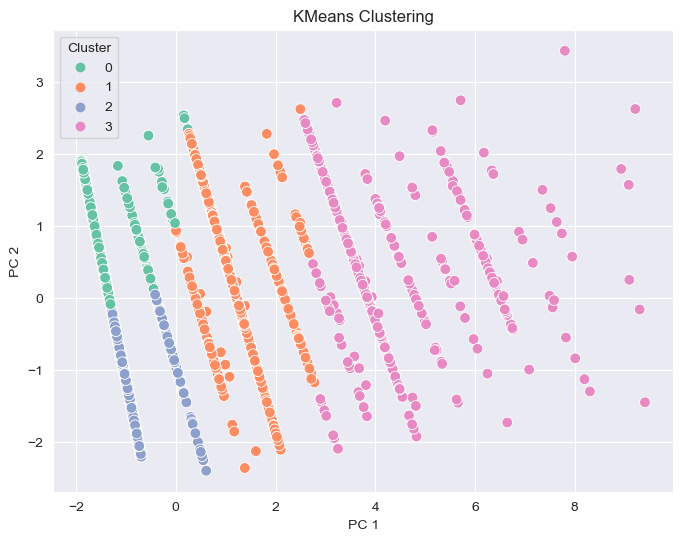

In [24]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

print("KMeans Silhouette Score:", silhouette_score(X, kmeans_labels))
plot_clusters_2D(X_pca, kmeans_labels, "KMeans Clustering")

## Step 9: DBSCAN Clustering

DBSCAN Silhouette Score: 0.3486689692547343


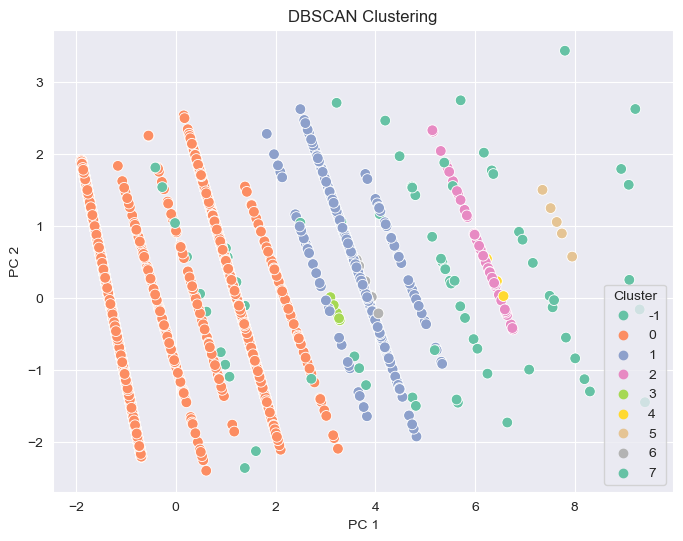

In [25]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1.5, min_samples=4)
db_labels = dbscan.fit_predict(X)

print("DBSCAN Silhouette Score:", silhouette_score(X, db_labels))
plot_clusters_2D(X_pca, db_labels, "DBSCAN Clustering")

## Step 10: Hierarchical Clustering

Hierarchical Clustering Silhouette Score: 0.2744468448621147


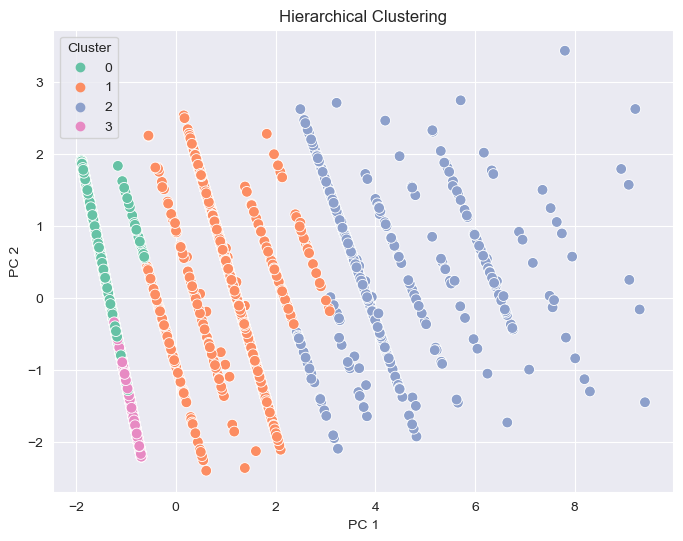

In [26]:
from sklearn.cluster import AgglomerativeClustering

hier = AgglomerativeClustering(n_clusters=4)
hier_labels = hier.fit_predict(X)

print("Hierarchical Clustering Silhouette Score:", silhouette_score(X, hier_labels))
plot_clusters_2D(X_pca, hier_labels, "Hierarchical Clustering")

## Step 11: Analyze PCA Components (ACP Analysis)

In [27]:
# Inverse-transform one-hot encoded feature names
cat_encoder = preprocessor.named_transformers_['cat']
cat_features = cat_encoder.get_feature_names_out(categorical)
all_features = numerical + list(cat_features)

pca_components_df = pd.DataFrame(pca.components_, columns=all_features, index=['PC1', 'PC2'])
display(pca_components_df.T.sort_values(by='PC1', ascending=False).head(10))  # PC1
display(pca_components_df.T.sort_values(by='PC2', ascending=False).head(10))  # PC2


,PC1,PC2
Num_Products_Bought,0.512839,0.183524
Num_Transactions,0.509945,0.161508
Num_Categories_Bought,0.505437,0.185373
Total_Amount_Spent,0.460324,-0.404216
Avg_Transaction_Amount,0.097620,-0.861565
City_Ville 191,0.000826,-0.000062
City_Ville 680,0.000820,0.000113
City_Ville 16,0.000801,0.000090
City_Ville 44,0.000761,0.000212
City_Ville 342,0.000758,-0.000667


,PC1,PC2
Num_Categories_Bought,0.505437,0.185373
Num_Products_Bought,0.512839,0.183524
Num_Transactions,0.509945,0.161508
City_Ville 753,-0.000162,0.001617
City_Ville 818,-0.000341,0.001286
City_Ville 321,0.000036,0.001241
City_Ville 278,0.000108,0.001123
City_Ville 112,0.000277,0.001109
City_Ville 63,0.000368,0.001064
City_Ville 308,-0.000359,0.001055


## Step 12: Assign Cluster Names Manually Based on PCA Loadings

In [33]:
# Sample KMeans label mapping based on interpretation
cluster_names = {
    0: "Loyal High Spenders",
    1: "Occasional Deal Seekers",
    2: "Explorers / Multi-Store",
    3: "New or Low Activity"
}

customer_info["Cluster"] = kmeans_labels
customer_info["Cluster_Label"] = customer_info["Cluster"].map(cluster_names)

# Preview
customer_info

C:\Users\aneek\AppData\Local\Temp\ipykernel_6884\174203801.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_info["Cluster"] = kmeans_labels
C:\Users\aneek\AppData\Local\Temp\ipykernel_6884\174203801.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_info["Cluster_Label"] = customer_info["Cluster"].map(cluster_names)


,CustomerID,CustomerName,City,PostalCode,Cluster,Cluster_Label
0,30001,Client 1,Ville 247,Pays,3,New or Low Activity
1,30003,Client 3,Ville 439,Pays,0,Loyal High Spenders
2,30004,Client 4,Ville 732,Pays,0,Loyal High Spenders
3,30005,Client 5,Ville 688,Pays,2,Explorers / Multi-Store
4,30006,Client 6,Ville 662,Pays,2,Explorers / Multi-Store
...,...,...,...,...,...,...
4412,36991,Client 6991,Ville 648,Pays,1,Occasional Deal Seekers
4413,36994,Client 6994,Ville 244,Pays,0,Loyal High Spenders
4414,36996,Client 6996,Ville 466,Pays,1,Occasional Deal Seekers
4415,36998,Client 6998,Ville 944,Pays,1,Occasional Deal Seekers
